In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
rm -rf /DB


In [3]:
!unzip '/content/drive/MyDrive/set_5.zip' -d '/DB'

Archive:  /content/drive/MyDrive/set_5.zip
  inflating: /DB/set_5.csv           


In [1]:
import pandas as pd
df = pd.read_csv("/home/farhana/Documents/chipless-RFID-tag-decoding-XGBClassifier/dataset/data_2/set_5.csv")

# Select the last column of the DataFrame
last_column = df.iloc[:, -2]
X_train = df.iloc[:, :-2]
print(X_train)

      index         0         1         2         3         4         5  \
0         0 -41.05859 -45.22265 -48.47461 -45.05859 -43.61133 -42.35547   
1         1 -41.71875 -44.71289 -47.19140 -45.77148 -44.66210 -42.69531   
2         2 -44.21094 -50.81836 -60.81640 -47.71289 -44.87500 -43.44727   
3         3 -45.32812 -50.61718 -52.30273 -45.50977 -43.71094 -42.24609   
4         4 -44.56055 -48.62890 -52.46288 -45.85742 -43.56641 -42.42383   
...     ...       ...       ...       ...       ...       ...       ...   
1425    465 -48.99023 -46.34179 -44.43359 -44.37500 -46.00390 -48.68750   
1426    466 -48.53516 -46.49219 -44.67773 -43.86914 -44.97070 -47.18946   
1427    467 -51.35156 -48.44921 -46.46680 -46.43164 -48.39453 -52.57421   
1428    468 -56.33007 -51.62499 -48.89062 -47.68750 -49.25390 -52.49804   
1429    469 -55.02539 -50.90234 -47.97852 -47.61328 -49.94141 -53.94921   

             6         7         8  ...      1591      1592      1593  \
0    -40.64453 -40.85742 -

In [2]:
import numpy as np

# Load your frequency response data into a variable, e.g., "frequency_response_data"
frequency_response_data = X_train

# 1. Center the data
mean = np.mean(frequency_response_data)
frequency_response_data -= mean

# 2. Scale the data
std_dev = np.std(frequency_response_data)
frequency_response_data /= std_dev

# 3. Clip extreme values (optional)
# You can set a threshold to clip values if needed
# frequency_response_data = np.clip(frequency_response_data, min_threshold, max_threshold)

# 4. Ensure the input range is appropriate for GAN activations
# If your GAN uses tanh activation in the generator, scale data to [-1, 1] range
# frequency_response_data *= 2  # Scale to [-1, 1]

# Now, your frequency response data is centered, scaled, and potentially clipped, ready for GAN training.
print(frequency_response_data)


         index         0         1         2         3         4         5  \
0    -1.213399  1.184518  0.487298  0.016102  0.603862  0.930629  1.212474   
1    -1.209172  1.073694  0.565471  0.216777  0.492534  0.768071  1.159879   
2    -1.204946  0.655316 -0.370812 -1.913967  0.189355  0.735134  1.043503   
3    -1.200719  0.467768 -0.339960 -0.582558  0.533403  0.915219  1.229402   
4    -1.196493  0.596625 -0.035055 -0.607603  0.479113  0.937578  1.201895   
...        ...       ...       ...       ...       ...       ...       ...   
1425  0.751962 -0.147011  0.315677  0.648056  0.710614  0.560489  0.232502   
1426  0.756189 -0.070615  0.292613  0.609877  0.789611  0.720329  0.464345   
1427  0.760416 -0.543420 -0.007499  0.330093  0.389440  0.190650 -0.369022   
1428  0.764642 -1.379191 -0.494509 -0.048956  0.193320  0.057702 -0.357234   
1429  0.768869 -1.160167 -0.383690  0.093683  0.204911 -0.048658 -0.581823   

             6         7         8  ...      1591      1592    

In [6]:
import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Assuming your preprocessed data is stored in a variable named "frequency_response_data"
data = frequency_response_data

# Normalize the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Define the WGAN architecture
latent_dim = 100  # Size of the random noise vector

# Generator
generator = keras.Sequential([
    keras.layers.Dense(128, input_dim=latent_dim, activation='relu'),
    keras.layers.Dense(data.shape[1], activation='linear')
])

# Critic (Discriminator for WGAN)
critic = keras.Sequential([
    keras.layers.Dense(64, input_dim=data.shape[1], activation='relu'),
    keras.layers.Dense(1, activation=None)  # No activation for WGAN
])

# Define the WGAN model
gan_input = keras.Input(shape=(latent_dim,))
generated_data = generator(gan_input)
real_data = keras.Input(shape=(data.shape[1],))
critic_output_generated = critic(generated_data)
critic_output_real = critic(real_data)

# Loss function
w_loss_gen = -tf.reduce_mean(critic_output_generated)
w_loss_real = -tf.reduce_mean(critic_output_real)

# Combined WGAN model
wgan = keras.Model(inputs=[gan_input, real_data], outputs=[w_loss_gen, w_loss_real])

# Optimizer
optimizer = keras.optimizers.RMSprop(learning_rate=0.00005)

# Custom training loop
@tf.function
def train_step(real_data_batch, noise):
    with tf.GradientTape() as tape:
        generated_data_batch = generator(noise)
        critic_output_generated = critic(generated_data_batch)
        critic_output_real = critic(real_data_batch)

        w_loss_gen = -tf.reduce_mean(critic_output_generated)
        w_loss_real = -tf.reduce_mean(critic_output_real)

        total_loss = w_loss_gen + w_loss_real

    gradients_wgan = tape.gradient(total_loss, wgan.trainable_variables)
    optimizer.apply_gradients(zip(gradients_wgan, wgan.trainable_variables))

    return w_loss_gen, w_loss_real

# Training the WGAN
batch_size = 32
epochs = 100
wgan_loss_gen_l = []
wgan_loss_real_l = []

for epoch in range(epochs):
    for _ in range(len(data) // batch_size):
        idx = np.random.randint(0, len(data), batch_size)
        real_data_batch = data[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        w_loss_gen, w_loss_real = train_step(real_data_batch, noise)

    # Print progress
    print(f"Epoch {epoch}/{epochs} | WGAN Loss: {tf.keras.backend.eval(w_loss_gen)}, {tf.keras.backend.eval(w_loss_real)}")
    wgan_loss_gen_l.append(tf.keras.backend.eval(w_loss_gen))
    wgan_loss_real_l.append(tf.keras.backend.eval(w_loss_real))

Epoch 0/100 | WGAN Loss: -5.9188995361328125, -4.72421932220459
Epoch 1/100 | WGAN Loss: -11.94692611694336, -8.176631927490234
Epoch 2/100 | WGAN Loss: -21.45128631591797, -12.545888900756836
Epoch 3/100 | WGAN Loss: -33.23419952392578, -14.298089027404785
Epoch 4/100 | WGAN Loss: -52.24769973754883, -18.145471572875977
Epoch 5/100 | WGAN Loss: -75.34553527832031, -16.57953643798828
Epoch 6/100 | WGAN Loss: -101.85594177246094, -13.502763748168945
Epoch 7/100 | WGAN Loss: -134.98489379882812, -18.775501251220703
Epoch 8/100 | WGAN Loss: -175.24258422851562, -19.610631942749023
Epoch 9/100 | WGAN Loss: -224.19676208496094, -16.358739852905273
Epoch 10/100 | WGAN Loss: -275.4803466796875, -18.712276458740234
Epoch 11/100 | WGAN Loss: -331.36376953125, -18.84174156188965
Epoch 12/100 | WGAN Loss: -383.6356506347656, -22.4285945892334
Epoch 13/100 | WGAN Loss: -456.10516357421875, -26.995689392089844
Epoch 14/100 | WGAN Loss: -527.8126831054688, -21.16187286376953
Epoch 15/100 | WGAN Loss

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Assuming your preprocessed data is stored in a variable named "frequency_response_data"
data = frequency_response_data

# Normalize the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Define the WGAN architecture
latent_dim = 100  # Size of the random noise vector

# Generator
generator = keras.Sequential([
    keras.layers.Dense(128, input_dim=latent_dim, activation='relu'),
    keras.layers.Dense(data.shape[1], activation='linear')
])

# Critic (Discriminator for WGAN)
critic = keras.Sequential([
    keras.layers.Dense(64, input_dim=data.shape[1], activation='relu'),
    keras.layers.Dense(1, activation=None)  # No activation for WGAN
])

# Define the WGAN model
gan_input = keras.Input(shape=(latent_dim,))
generated_data = generator(gan_input)
real_data = keras.Input(shape=(data.shape[1],))
critic_output_generated = critic(generated_data)
critic_output_real = critic(real_data)

# Loss function
w_loss_gen = -tf.reduce_mean(critic_output_generated)
w_loss_real = -tf.reduce_mean(critic_output_real)

# Combined WGAN model
wgan = keras.Model(inputs=[gan_input, real_data], outputs=[w_loss_gen, w_loss_real])

# Optimizer
optimizer = keras.optimizers.RMSprop(learning_rate=0.00005)

# Custom training loop
@tf.function
def train_step(real_data_batch, noise):
    with tf.GradientTape() as tape:
        generated_data_batch = generator(noise)
        critic_output_generated = critic(generated_data_batch)
        critic_output_real = critic(real_data_batch)

        w_loss_gen = -tf.reduce_mean(critic_output_generated)
        w_loss_real = -tf.reduce_mean(critic_output_real)

        total_loss = w_loss_gen + w_loss_real

    gradients_wgan = tape.gradient(total_loss, wgan.trainable_variables)
    optimizer.apply_gradients(zip(gradients_wgan, wgan.trainable_variables))

    return w_loss_gen, w_loss_real

# Training the WGAN
batch_size = 32
epochs = 10

for epoch in range(epochs):
    for _ in range(len(data) // batch_size):
        idx = np.random.randint(0, len(data), batch_size)
        real_data_batch = data[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        w_loss_gen, w_loss_real = train_step(real_data_batch, noise)

    # Print progress
    print(f"Epoch {epoch}/{epochs} | WGAN Loss: {tf.keras.backend.eval(w_loss_gen)}, {tf.keras.backend.eval(w_loss_real)}")

# Anomaly Detection
def detect_anomalies_wgan(data):
    noise = np.random.normal(0, 1, (data.shape[0], latent_dim))
    generated_data = generator.predict(noise)
    critic_output = critic.predict(data)
    anomaly_scores = -critic_output  # Invert for anomaly detection
    return anomaly_scores

# Detect anomalies in your data using the WGAN
anomaly_scores_wgan = detect_anomalies_wgan(data)

# Set a threshold to classify anomalies
threshold_wgan = -0.5  # Adjust as needed
anomalies_wgan = anomaly_scores_wgan > threshold_wgan


Epoch 0/10 | WGAN Loss: -6.284127712249756, -6.229816436767578
Epoch 1/10 | WGAN Loss: -13.250825881958008, -10.739173889160156
Epoch 2/10 | WGAN Loss: -24.533100128173828, -13.315731048583984
Epoch 3/10 | WGAN Loss: -38.87641525268555, -11.428281784057617
Epoch 4/10 | WGAN Loss: -55.527313232421875, -16.83355140686035
Epoch 5/10 | WGAN Loss: -85.27204132080078, -23.583784103393555
Epoch 6/10 | WGAN Loss: -119.92345428466797, -19.37409019470215
Epoch 7/10 | WGAN Loss: -152.26739501953125, -18.80560874938965
Epoch 8/10 | WGAN Loss: -199.52828979492188, -18.874507904052734
Epoch 9/10 | WGAN Loss: -264.7488708496094, -21.15077018737793


/home/farhana/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [7]:
wgan_loss_gen_l

[-5.9188995,
 -11.946926,
 -21.451286,
 -33.2342,
 -52.2477,
 -75.345535,
 -101.85594,
 -134.9849,
 -175.24258,
 -224.19676,
 -275.48035,
 -331.36377,
 -383.63565,
 -456.10516,
 -527.8127,
 -646.6803,
 -717.66125,
 -786.17694,
 -922.13257,
 -1089.9412,
 -1184.4373,
 -1390.0146,
 -1504.2424,
 -1611.0709,
 -1809.4015,
 -2017.4933,
 -2276.8179,
 -2418.0256,
 -2683.8523,
 -2802.9226,
 -3136.8538,
 -3368.6208,
 -3516.7612,
 -3983.4316,
 -4224.837,
 -4414.1455,
 -5079.258,
 -5358.701,
 -5569.7393,
 -5873.0215,
 -6401.4863,
 -6693.461,
 -7117.043,
 -8058.27,
 -8046.424,
 -8603.112,
 -9052.245,
 -9857.319,
 -10568.822,
 -10834.925,
 -12200.381,
 -12764.96,
 -13061.312,
 -13139.491,
 -14316.121,
 -14994.729,
 -15893.12,
 -16022.808,
 -17802.168,
 -18198.25,
 -18576.46,
 -20415.047,
 -20233.432,
 -22286.723,
 -23065.174,
 -23239.816,
 -24496.426,
 -24908.156,
 -28233.223,
 -29657.852,
 -28706.27,
 -31123.285,
 -30981.404,
 -33578.156,
 -35737.43,
 -37725.938,
 -35550.61,
 -38880.55,
 -40959.016,

In [35]:
print("Indices of anomalies detected by WGAN:")
print(np.where(anomalies_wgan))

Indices of anomalies detected by WGAN:
(array([  39,  421,  423,  424,  458,  540,  767,  779,  788,  791,  792,
        793,  810,  818,  944,  946,  947,  949,  951,  956, 1171, 1181,
       1186, 1381, 1384]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0]))


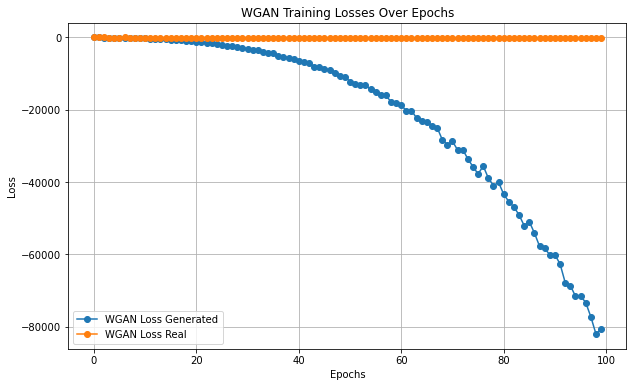

In [8]:
import matplotlib.pyplot as plt

# Your epoch and loss data
epochs = list(range(100))
wgan_loss_gen = wgan_loss_gen_l  # Replace ellipsis with your data
wgan_loss_real = wgan_loss_real_l

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(epochs, wgan_loss_gen, label='WGAN Loss Generated', marker='o')
plt.plot(epochs, wgan_loss_real, label='WGAN Loss Real', marker='o')

plt.title('WGAN Training Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
